In [13]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

xs_face = np.load("saved_npy/xs_face_no_pose.npy")
xs = np.load("saved_npy/xs_no_pose.npy")
ys = np.load("saved_npy/ys_no_pose.npy")

xs_face_train, xs_face_test, xs_train, xs_test, ys_train, ys_test  = train_test_split(xs_face, xs, ys, test_size=0.1, random_state=42)
xs_face_train, xs_face_valid, xs_train, xs_valid, ys_train, ys_valid  = train_test_split(xs_face_train, xs_train, ys_train, test_size=0.1, random_state=42)

print("Train, Valid, Test Size:")
print(xs_face_train.shape[0])
print(xs_face_valid.shape[0])
print(xs_face_test.shape[0])

Train, Valid, Test Size:
550
62
69


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 7, 7, 256)]  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 7, 7, 256)]  0                                            
__________________________________________________________________________________________________
flatten_18 (Flatten)            (None, 12544)        0           input_19[0][0]                   
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 12544)        0           input_20[0][0]                   
______________________________________________________________________________________

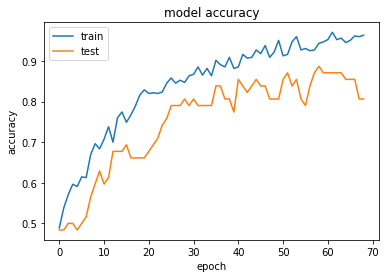

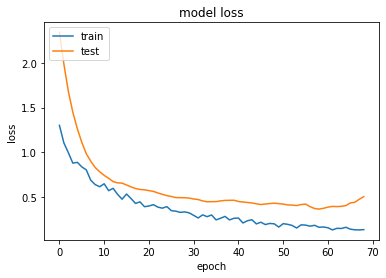

In [12]:
# Face.
faceInput = keras.layers.Input(shape=(7,7,256,))
flattenFace = keras.layers.Flatten()(faceInput)
denseFace = keras.layers.Dense(64, activation='relu')(flattenFace)
denseFace = BatchNormalization()(denseFace)
denseFace = keras.layers.Dropout(0.2)(denseFace)


# Pose.
embedInput = keras.layers.Input(shape=(7,7,256,))
flattenEmbed = keras.layers.Flatten()(embedInput)
denseEmbed = keras.layers.Dense(64, activation='relu')(flattenEmbed)
denseEmbed = BatchNormalization()(denseEmbed)
denseEmbed = keras.layers.Dropout(0.2)(denseEmbed)


# Concat feature and pass to output layer.
merged = keras.layers.Concatenate(axis=1)([denseFace, denseEmbed])
merged = keras.layers.Dense(32, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = keras.layers.Dropout(0.2)(merged)

output = keras.layers.Dense(2, activation='softmax', use_bias=False)(merged)
model = keras.models.Model(inputs=[faceInput, embedInput], outputs=output)

callbacks = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='saved_models/best_model', monitor='val_loss', save_best_only=True)]
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model.summary()
history = model.fit(
    [xs_face_train, xs_train], 
    ys_train, 
    batch_size=64, 
    epochs=300,
    validation_data=([xs_face_valid, xs_valid], ys_valid),
    callbacks=callbacks,
)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

3/3 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.8116 - recall_5: 0.8116 - auc_7: 0.8796
Accuracy on test set 0.8116
Auc on test set 0.8796
Confusion Matrix:
[[22  4]
 [ 9 34]]


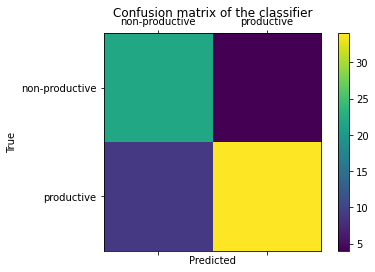

In [53]:
# Visulize result on test set.

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load best model and get confusion matrix on test set.
best_model = keras.models.load_model('saved_models/best_model')
loss_test, accuracy_test, recall_test, auc_test = best_model.evaluate([xs_face_test, xs_test], ys_test)
ys_pred = best_model.predict([xs_face_test, xs_test])
cm = confusion_matrix(ys_test.argmax(axis=1), ys_pred.argmax(axis=1))
print("==========================")
print("Accuracy on test set %.4f" % (accuracy_test))
print("Auc on test set %.4f" %(auc_test))
print("Confusion Matrix:")
print(cm)
labels = ['non-productive', 'productive']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()